In [1]:
# Loading R packages
library(reshape)
library(ggplot2)
library(phyloseq)
library(dplyr)
library(wesanderson)
library(vegan)
library(ggrepel)


Attaching package: ‘dplyr’

The following object is masked from ‘package:reshape’:

    rename

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: permute
Loading required package: lattice
This is vegan 2.4-4


In [2]:
# Importing individual sample datasets
ps.wu = readRDS(file = "wu.ps")
ps.imparato = readRDS(file = "imparato.ps")
ps.yao = readRDS(file = "yao.ps")
ps.dai2016 = readRDS(file = "dai2016.ps")
ps.dai2017 = readRDS(file = "dai2017.ps")
ps.song = readRDS(file = "song.ps")
ps.whitman = readRDS(file = "whitman.ps")

In [3]:
ps.glom.genus = readRDS(file = "ps.glom.genus.ps")
#cutoff=1000
#ps.glom.genus = prune_samples(sample_sums(ps.glom.genus)>cutoff, ps.glom.genus)
#ps.glom.genus = rarefy_even_depth(ps.glom.genus)
ps.norm = transform_sample_counts(ps.glom.genus, function(x) x/sum(x)) 
ps.norm = subset_samples(ps.norm, PyOM != "OM")
ps.norm = prune_taxa(taxa_sums(ps.norm)>0, ps.norm)
ps.norm = subset_samples(ps.norm,Incubation_Time_Weeks != 0)
ps.norm = subset_samples(ps.norm,!(Incubation_Time_Weeks ==24 & Author == "Song"))
# Song doesn't have a control sample at 24 weeks

In [4]:
# Two options for ordinations
ord_full_pcoa = ordinate(ps.norm, method = "PCoA", distance = "bray")
ord_full_nmds = ordinate(ps.norm, method = "NMDS", distance = "bray", trymax=1000)

Run 0 stress 0.1788728 
Run 1 stress 0.1503899 
... New best solution
... Procrustes: rmse 0.03567522  max resid 0.3470784 
Run 2 stress 0.2312884 
Run 3 stress 0.1869855 
Run 4 stress 0.2004327 
Run 5 stress 0.1503901 
... Procrustes: rmse 4.159994e-05  max resid 0.0003990197 
... Similar to previous best
Run 6 stress 0.1503869 
... New best solution
... Procrustes: rmse 0.000388226  max resid 0.005453965 
... Similar to previous best
Run 7 stress 0.1713557 
Run 8 stress 0.1724234 
Run 9 stress 0.2014642 
Run 10 stress 0.150387 
... Procrustes: rmse 0.0001376978  max resid 0.0009674317 
... Similar to previous best
Run 11 stress 0.1946511 
Run 12 stress 0.1539546 
Run 13 stress 0.2073477 
Run 14 stress 0.1848623 
Run 15 stress 0.1949204 
Run 16 stress 0.1503903 
... Procrustes: rmse 0.0003582212  max resid 0.004974252 
... Similar to previous best
Run 17 stress 0.1606217 
Run 18 stress 0.1804945 
Run 19 stress 0.1795367 
Run 20 stress 0.1744393 
*** Solution reached


In [5]:
ord_full_nmds


Call:
metaMDS(comm = veganifyOTU(physeq), distance = distance, trymax = 1000) 

global Multidimensional Scaling using monoMDS

Data:     veganifyOTU(physeq) 
Distance: bray 

Dimensions: 2 
Stress:     0.1503869 
Stress type 1, weak ties
Two convergent solutions found after 20 tries
Scaling: centring, PC rotation, halfchange scaling 
Species: expanded scores based on ‘veganifyOTU(physeq)’ 


In [6]:
# Formatting the sample data for convenience of plotting

df = data.frame(sample_data(ps.norm))

df = df %>%
    mutate(SoilXLabel = paste(SoilType,Incubation_Time_Weeks,PyOM,Feedstock,t.per.ha.PyOM,g.per.kg.PyOM,PyOM.Temp))%>%
    mutate(CharType = paste(PyOM,Feedstock,t.per.ha.PyOM,g.per.kg.PyOM,PyOM.Temp,Incubation_Time_Weeks))%>%
    mutate(Time_Category = ifelse(PyOM=="Control", "Control",
                                 ifelse(as.numeric(Incubation_Time_Weeks)<100, "PyOM Short","PyOM Long")))%>%
    mutate(Time_Facet = ifelse(Incubation_Time_Weeks == 0, "Initial",
                                 ifelse(as.numeric(Incubation_Time_Weeks)<100, "PyOM Short","PyOM Long")))%>%
    mutate(Temp_Category = ifelse(PyOM=="Control", "Control",paste(PyOM,PyOM.Temp)))%>%
    mutate(SoilTypeName = paste(SoilType," (",Author,")",sep=""), SoilType)
df = sample_data(df)
row.names(df) = row.names(sample_data(ps.norm))

sample_data(ps.norm) = df

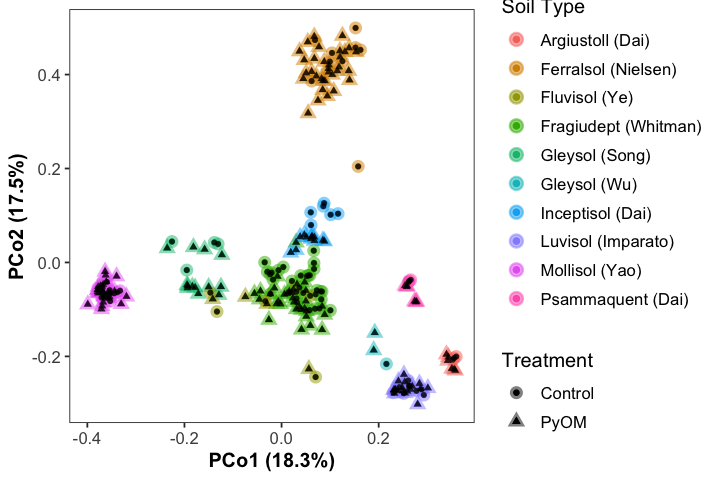

In [7]:
options(repr.plot.width=6, repr.plot.height=4)

p = plot_ordination(ps.norm, ord_full_pcoa, axes=c(1,2), color="SoilTypeName", shape="PyOM")

p = p + geom_point(size=3, stroke=1, alpha=0.5)
p = p + geom_point(size=1, stroke=1, alpha=0.8, color="black") #+ scale_shape_manual(values=c(21,23))

p = p + theme_bw() + theme(legend.position="right") +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
    ,axis.title = element_text(size=12, face="bold"),
        axis.text = element_text(size=10),
        legend.text = element_text(size=10),
        legend.title = element_text(size = 12),
        strip.background = element_rect(colour="white", fill="white")) #+ facet_wrap(~SoilType, scales="free")
p = p + guides(shape=guide_legend(title="Treatment"),color=guide_legend(title="Soil Type"))
p = p + ylab("PCo2 (17.5%)")
p = p + xlab("PCo1 (18.3%)")
p

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
Groups,1,0.04874976,0.04874976,2.086136,0.1499297
Residuals,243,5.67853215,0.02336845,NA,NA


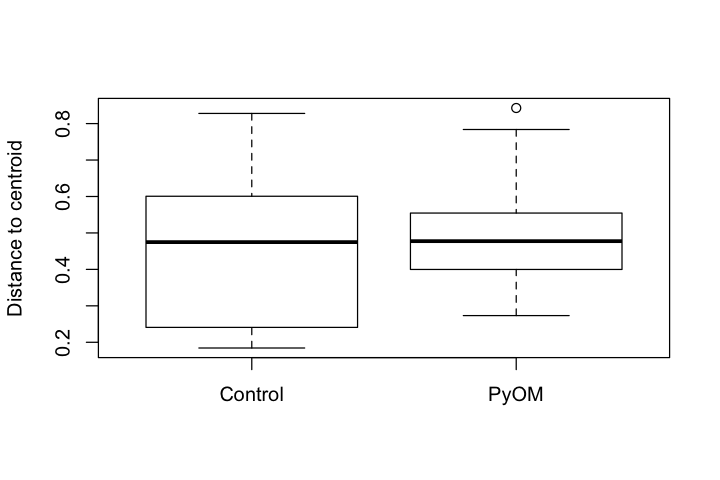

In [8]:
d = distance(ps.norm, method = "bray")
samdat = sample_data(ps.norm)
groups = as.factor(samdat$PyOM)
x = betadisper(d, groups)
boxplot(x, ylab = "Distance to centroid")
anova(x)
# Different samples do not have different dispersions; thus we can interpret the results of the adonis.

In [9]:
metadata = as(sample_data(ps.norm), "data.frame")
adonis(distance(ps.norm, method="bray") ~ SoilTypeName * PyOM, data = metadata)

# All factors are significant, including the interaction
# I.e., soiltype / studies have different communities
# PyOM affects the communities
# And PyOM affects different communities different ways


Call:
adonis(formula = distance(ps.norm, method = "bray") ~ SoilTypeName *      PyOM, data = metadata) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                   Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
SoilTypeName        9    49.733  5.5259 124.992 0.81403  0.001 ***
PyOM                1     0.188  0.1878   4.249 0.00307  0.001 ***
SoilTypeName:PyOM   9     1.227  0.1363   3.083 0.02008  0.001 ***
Residuals         225     9.947  0.0442         0.16282           
Total             244    61.095                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

### Trying distance-based partial redundancy analysis

Call: capscale(formula = taxa ~ samdat$PyOM +
Condition(samdat$SoilTypeName), distance = "bray")

                Inertia Proportion Eigenvals Rank
Total         61.094989   1.000000 63.490605     
Conditional   49.733159   0.814030 49.740062    9
Constrained    0.187843   0.003075  0.198660    1
Unconstrained 11.173987   0.182895 13.551883  143
Imaginary                          -2.395616  101
Inertia is squared Bray distance 

Eigenvalues for constrained axes:
   CAP1 
0.19866 

Eigenvalues for unconstrained axes:
  MDS1   MDS2   MDS3   MDS4   MDS5   MDS6   MDS7   MDS8 
1.0814 0.8253 0.7236 0.6678 0.5687 0.5206 0.4694 0.4320 
(Showed only 8 of all 143 unconstrained eigenvalues)


,Df,SumOfSqs,F,Pr(>F)
samdat$PyOM,1,0.187843,3.933713,0.001
Residual,234,11.173987,NA,NA


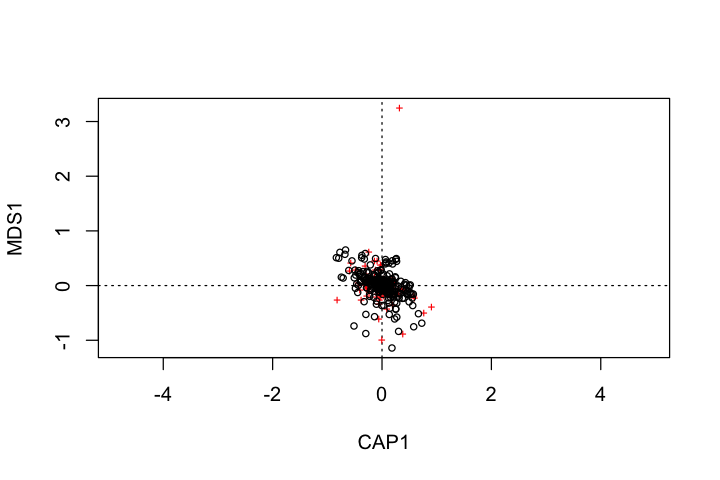

In [37]:
# capscale (vegan):
# Distance-based redundancy analysis (dbRDA) is an ordination method similar to Redundancy Analysis (rda), 
# but it allows non-Euclidean dissimilarity indices, such as Manhattan or Bray–Curtis distance. 

# Get sample data and OTU table
samdat = sample_data(ps.norm)
taxa = t(otu_table(ps.norm))

# Run partial distance-based redundancy analysis
# where we control for (condition on) soil type
# and test for (constrain by) PyOM addition status
pdbRDA = capscale(taxa ~ samdat$PyOM + Condition(samdat$SoilTypeName), dist="bray")
pdbRDA

# Look at effect of PyOM
anova(pdbRDA, by="term")

# Plot data for samples (sites) and taxa (species)
plot(pdbRDA,choices=c("CAP1","MDS1"),display = c("sites","species"),scaling=3)

In [11]:
# Save the scores for each sample (choosing the constrained on (PyOM) and the first three others)
SiteScores = data.frame(scores(pdbRDA,choices=c("CAP1","MDS1","MDS2","MDS3"),display = c("sites"),scaling=3))
SiteScores$SampleID = row.names(SiteScores)
head(SiteScores)

,CAP1,MDS1,MDS2,MDS3,SampleID
S101,-0.321316392,0.16094423,0.2390565572,0.1317344,S101
S102,-0.006838987,-0.01742827,-0.0001925645,0.3089289,S102
S103,-0.102613590,-0.34081775,-0.1516437923,0.1240814,S103
S104,0.579465178,-0.75319138,-0.2523474915,-0.4458186,S104
S106,0.132121766,-0.52815891,-0.2707706522,-0.2979806,S106
S107,-0.058226833,-0.11800659,0.1126783210,0.2010758,S107


In [12]:
# Collect the sample data and pull out just the variables of interest
samdat=sample_data(ps.norm)
samdat$SampleID = row.names(samdat)
samdat = samdat %>% select(PyOM,SampleID,SoilTypeName)
head(samdat)

,PyOM,SampleID,SoilTypeName
S101,Control,S101,Fragiudept (Whitman)
S102,PyOM,S102,Fragiudept (Whitman)
S103,Control,S103,Fragiudept (Whitman)
S104,PyOM,S104,Fragiudept (Whitman)
S106,Control,S106,Fragiudept (Whitman)
S107,PyOM,S107,Fragiudept (Whitman)


In [13]:
# Join the partial dbRDA scores with the sample properties for plotting
PlotDataSites = data.frame(SiteScores,samdat)

Warning message:
“Removed 1 rows containing missing values (geom_point).”

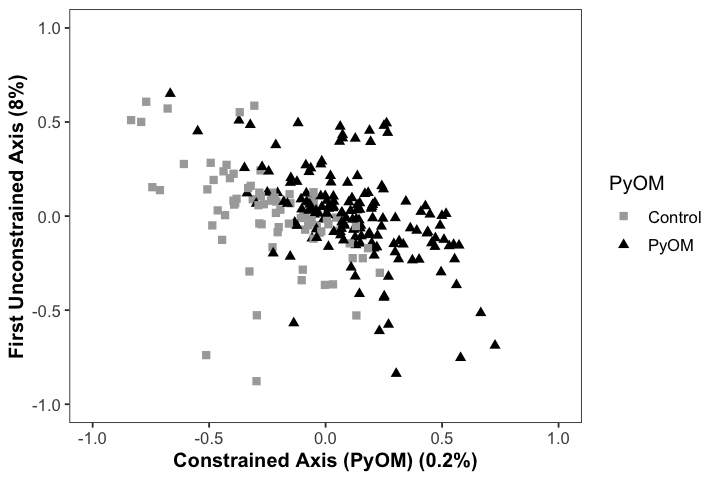

In [14]:
# Plot the partial dbRDA, coloring by PyOM status
p = ggplot(PlotDataSites,aes(x=CAP1,y=MDS1,shape=PyOM,colour=PyOM))
p = p + geom_point(size=2) + scale_colour_manual(values=c("darkgrey","black"))
p = p + scale_shape_manual(values=c(15,17))
p = p + ylim(c(-1,1))  + xlim(c(-1,1))
p = p + theme_bw() + theme(legend.position="right") +
  theme(
    plot.background = element_blank()
    ,panel.grid.major = element_blank()
    ,panel.grid.minor = element_blank()
    ,axis.title = element_text(size=12, face="bold"),
    axis.text = element_text(size=10),
    legend.text = element_text(size=10),
    legend.title = element_text(size = 12),
    strip.background = element_rect(colour="white", fill="white"))
p = p + xlab("Constrained Axis (PyOM) (0.3%)") + ylab("First Unconstrained Axis (8%)")
p

In [15]:
#saveRDS(PlotData,"PlotDataSites.df")

In [48]:
# Save the scores for each taxon (choosing the constrained on (PyOM) and the first three others)
TaxaScores = data.frame(scores(pdbRDA,choices=c("CAP1","MDS1","MDS2","MDS3"),display = c("species"),scaling=3))
TaxaScores$Genus = row.names(TaxaScores)
head(TaxaScores)

# Save the taxonomy data
taxa=data.frame(tax_table(ps.norm))
taxa$Genus = row.names(taxa)
head(taxa)

# Combine taxonomy data with taxon scores
PlotDataTaxa = data.frame(TaxaScores,taxa)

,CAP1,MDS1,MDS2,MDS3,Genus
Bradyrhizobium,0.0096669569,0.38912204,0.01170029,0.58828995,Bradyrhizobium
Sphingomonas,-0.0003741452,-0.98997857,-0.21608411,2.55331205,Sphingomonas
Massilia,0.3807768647,-0.87960358,-0.74175954,-0.06656833,Massilia
Bacillus,-0.4824000853,0.28924869,0.96654450,-0.52142567,Bacillus
Nitrospira,-0.0292420148,0.29972943,0.16344764,0.09164953,Nitrospira
Rhizobacter,0.0712939265,-0.03811538,-0.03749074,-0.01984378,Rhizobacter


,Domain,Phylum,Class,Order,Family,Genus,Species
Bradyrhizobium,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Xanthobacteraceae,Bradyrhizobium,NA
Sphingomonas,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas,NA
Massilia,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Massilia,NA
Bacillus,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,NA
Nitrospira,Bacteria,Nitrospirae,Nitrospira,Nitrospirales,Nitrospiraceae,Nitrospira,NA
Rhizobacter,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Rhizobacter,NA


In [49]:
# Get the taxa that provide the most explanatory power on the constrained axis
PlotDataTaxa = PlotDataTaxa %>%
    #mutate(AbsCAP1 = abs(CAP1))%>%
    #arrange(-AbsCAP1)%>%
    arrange(-CAP1)%>%
    mutate(GenusLabel="")
PlotDataTaxa[1:11,]$GenusLabel = PlotDataTaxa[1:11,]$Genus

In [50]:
# Get most abundant phyla (of interest), excluding Cyanobacteria (just for plot colours)
Phyla = PlotDataTaxa %>%
  group_by(Phylum)%>%
  summarize(Total = n())%>%
  arrange(-Total)
Phyla$PhylumColour = "Other"
Phyla$PhylumColour[1:6] = paste(Phyla$Phylum[1:6])
Phyla$PhylumColour[Phyla$Phylum=="Cyanobacteria"] = "Other"
head(Phyla)

# Add that phylum colour column to the taxa data frame
PlotDataTaxa = merge(PlotDataTaxa,Phyla,by="Phylum")

Phylum,Total,PhylumColour
Proteobacteria,288,Proteobacteria
Firmicutes,127,Firmicutes
Actinobacteria,95,Actinobacteria
Bacteroidetes,66,Bacteroidetes
Cyanobacteria,43,Other
Acidobacteria,25,Acidobacteria


Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”

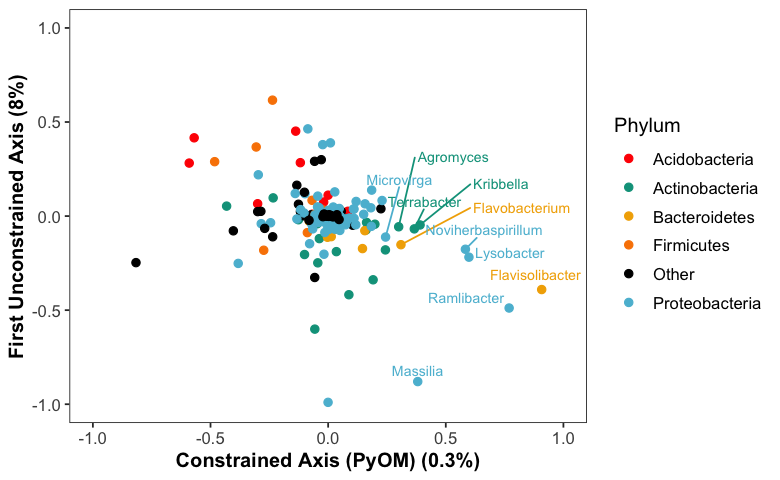

In [52]:
options(repr.plot.width=6.5, repr.plot.height=4)
p = ggplot(PlotDataTaxa,aes(x=CAP1,y=MDS1,color=PhylumColour))
p = p + geom_point(size=2) + geom_text_repel(aes(label=GenusLabel),size=3,show.legend = FALSE,vjust=1)
p = p + scale_colour_manual(values=c(wes_palette("Darjeeling1")[1:4],"black",wes_palette("Darjeeling1")[5]))
p = p + theme_bw() + theme(legend.position="right") +
  theme(
    plot.background = element_blank()
    ,panel.grid.major = element_blank()
    ,panel.grid.minor = element_blank()
    ,axis.title = element_text(size=12, face="bold"),
    axis.text = element_text(size=10),
    legend.text = element_text(size=10),
    legend.title = element_text(size = 12),
    strip.background = element_rect(colour="white", fill="white"))
p = p + guides(color=guide_legend(title="Phylum"))
p = p + xlab("Constrained Axis (PyOM) (0.3%)") + ylab("First Unconstrained Axis (8%)")
p = p + ylim(c(-1,1))  + xlim(c(-1,1))
p

In [35]:
#saveRDS(PlotDataTaxa,"PlotDataTaxa.df")